In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def turbine_distances(xvec):
    N = len(xvec) // 2
    x = xvec[:N]
    y = xvec[N:]
    X = np.tile(x, (N, 1))
    Y = np.tile(y, (N, 1))
    return np.sqrt((X - X.T) ** 2 + (Y - Y.T) ** 2)

In [ ]:
turbine_distances([1,2,3,4])

array([[0.        , 1.41421356],
       [1.41421356, 0.        ]])

In [ ]:
def constraints(xvec, rho1, rho2):
    # constraint 1: distance between turbines
    D = 0.1   #Diameter of turbine
    max_dist = 2 * D
    Lx=np.pi  #Size of farm  Lx*Lx
    d = turbine_distances(xvec)
    N=len(xvec) // 2
    mask = (d < max_dist) - np.eye(N)   #np.eye(N)  is used to remove the penalty along the principal diagonal
    violation = mask * d
    penalty_1 = 0.5 * np.sum(violation) # sum of all the distance violations between turbines

    # constraint 2: within boundaries
    mask1 = xvec < 0
    mask2 = xvec > Lx
    penalty_2 = np.sum(np.abs(mask1 * xvec) + np.abs(mask2 * (xvec - Lx)))
    
    res = (rho1 * penalty_1) ** 2 + (rho2 * penalty_2) ** 2
    return res

In [ ]:
def jensen_wakes(xvec, wind, plot_flag):
    N = len(xvec) // 2
    r0 = 0.05
    alpha = 0.1
    
    u_inf = float(wind)

    X = xvec[:N]
    Y = xvec[N:]
    
    V = u_inf * np.ones_like(X)
    
    for turb_ind in range(N):
        X_prime = X - xvec[turb_ind]
        Y_prime = Y - xvec[turb_ind + N]
        mask = (X_prime > 0) & (np.abs(Y_prime) < (alpha * X_prime + r0))
        V *= 1 - 2 / 3 * mask * r0 ** 2 / (r0 + alpha * X_prime) ** 2

    
    vel = V
    
    if plot_flag == 1:
        grid = 1000
        dx = np.pi / grid
        xmin, xmax, ymin, ymax = 0, np.pi, 0, np.pi
        xgrid_rot = np.linspace(xmin, xmax, grid)
        ygrid_rot = np.linspace(ymin, ymax, grid)
        
        X, Y = np.meshgrid(xgrid_rot, ygrid_rot)
        
        V = u_inf * np.ones_like(X)
      
        for turb_ind in range(N):
            X_prime = X - xvec[turb_ind]
            Y_prime = Y - xvec[turb_ind + N]
            mask = (X_prime > 0) & (np.abs(Y_prime) < (alpha * X_prime + r0))
            V *= 1 - 2 / 3 * mask * r0 ** 2 / (r0 + alpha * X_prime) ** 2
        
        
        plt.pcolor(X, Y, V)
        plt.colorbar()
        plt.plot(xvec[:N], xvec[N:], 'r*')
        plt.axis('equal')
        plt.xlim([0, np.pi])
        plt.ylim([0, np.pi])
        plt.xlabel('X')
        plt.ylabel('Y')
    
    total_power = sum(vel ** 3)
    
    return total_power

In [ ]:
def farm_cost(xvec, wind):
    cost = 0
    temp = jensen_wakes(xvec, wind, 0)
    cost -= temp
    return cost

In [ ]:
def pattern_search(xvec, step_break, wind_rose):
    step0 = 2.048
    cost0 = farm_cost(xvec, wind_rose)
    step = step0
    bestcost = cost0
    iter_ = 1
    bestcost_vec = [bestcost]
    N = len(xvec) // 2
    rho1 = 10
    rho2 = 10
    while step >= step_break:
        dir_ = np.zeros_like(xvec)
        dir_[0] = 1
        last_best = bestcost
        for ind in range(N * 2):
            search_point = xvec + step * dir_
            cost = farm_cost(search_point, wind_rose)
            iter_ += 1
            bestcost_vec.append(bestcost)
            penalty = constraints(search_point, rho1, rho2)
            cost += penalty
            if cost < bestcost:
                xvec = search_point
                bestcost = cost
                rho1 *= 1.1
                rho2 *= 1.1
            else:
                dir_[ind] = -1
                search_point = xvec + step * dir_
                cost = farm_cost(search_point, wind_rose)
                penalty = constraints(search_point, rho1, rho2)
                cost += penalty
                iter_ += 1
                bestcost_vec.append(bestcost)
                if cost < bestcost:
                    xvec = search_point
                    bestcost = cost
                    rho1 *= 1.1
                    rho2 *= 1.1
            dir_[ind] = 0
            if ind<2*N-1:
               dir_[ind + 1] = 1
        if last_best == bestcost:
            step /= 2
    res =[(xvec),bestcost,iter_,bestcost_vec]
    return res

In [ ]:
wind_speed=4.0

In [ ]:
N=30 #number of turbines

In [ ]:
xvec1 = np.random.uniform(low=0.001, high=np.pi-0.001, size=2*N)

In [ ]:
ans=pattern_search(xvec1, 0.001, wind_speed)

1212.8235271890173

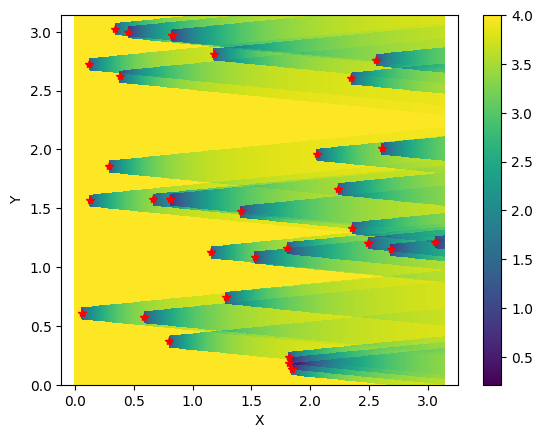

In [ ]:
#initial configurations
jensen_wakes(xvec1, wind_speed, 1)

1826.4582250354028

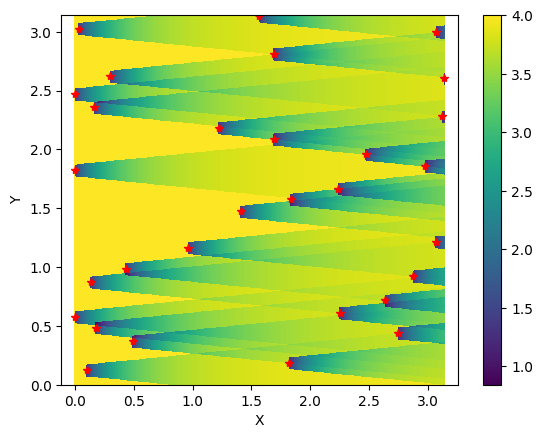

In [ ]:
#Final Configuration
jensen_wakes(ans[0], wind_speed, 1)

In [ ]:
efficiency = -1*np.array(ans[3])/(N*(wind_speed**3))

In [ ]:
num_iter=ans[2]

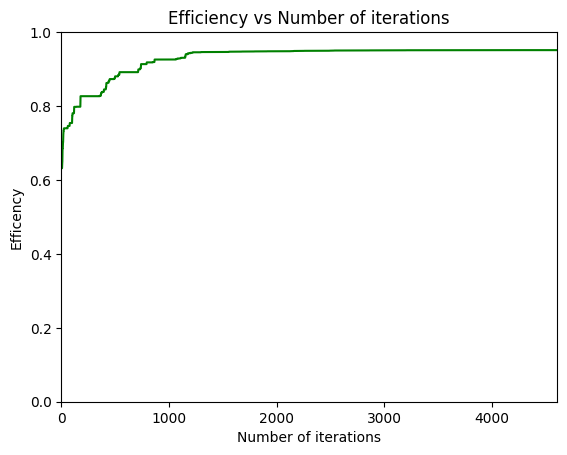

In [ ]:
plt.plot(np.arange(num_iter)+1, efficiency, 'g')
plt.ylim(0.0, 1.0)
plt.xlim(0, num_iter)
plt.xlabel('Number of iterations')
plt.ylabel('Efficency')
plt.title("Efficiency vs Number of iterations")
plt.show()

In [ ]:
temp=[1695, 1493,  493,  741,  181,  270, 1789, 1266, 2979, 1082, 1086,
       1529,  989, 2072,  432, 2443, 2316,  810,  133, 2826, 2716, 1762,
       2026, 2574, 3123, 2082,  786, 3061,  936,  471, 1470, 1019, 3040,
        555,   73, 2284,  216, 2575, 2732,   86, 1280, 2360,  116, 1493,
       1412, 2845,   40,  560,  845,    9, 1541,  582, 2317, 3085, 1961,
       1981, 2151, 2321, 1559, 1830]

In [ ]:
N = len(temp) // 2
coor=[]
for i in range(2*N):
  if i%2==0:
    coor.append(temp[i])

for i in range(2*N):
  if i%2!=0:
    coor.append(temp[i])
  

In [ ]:
def jensen_wakes1(xvec, wind, plot_flag):
    N = len(xvec) // 2
    r0 = 50
    alpha = 0.1
    
    u_inf = float(wind)

    X = xvec[:N]
    Y = xvec[N:]
    
    V = u_inf * np.ones_like(X)
    
    for turb_ind in range(N):
        X_prime = X - xvec[turb_ind]
        Y_prime = Y - xvec[turb_ind + N]
        mask = (X_prime > 0) & (np.abs(Y_prime) < (alpha * X_prime + r0))
        V *= 1 - 2 / 3 * mask * r0 ** 2 / (r0 + alpha * X_prime) ** 2

    
    vel = V
    
    if plot_flag == 1:
        grid = 1000
        dx = 3142 / grid
        xmin, xmax, ymin, ymax = 0, 3142, 0, 3142
        xgrid_rot = np.linspace(xmin, xmax, grid)
        ygrid_rot = np.linspace(ymin, ymax, grid)
        
        X, Y = np.meshgrid(xgrid_rot, ygrid_rot)
        
        V = u_inf * np.ones_like(X)
      
        for turb_ind in range(N):
            X_prime = X - xvec[turb_ind]
            Y_prime = Y - xvec[turb_ind + N]
            mask = (X_prime > 0) & (np.abs(Y_prime) < (alpha * X_prime + r0))
            V *= 1 - 2 / 3 * mask * r0 ** 2 / (r0 + alpha * X_prime) ** 2
        
        
        plt.pcolor(X, Y, V)
        plt.colorbar()
        plt.plot(xvec[:N], xvec[N:], 'r*')
        plt.axis('equal')
        plt.xlim([0, 3142])
        plt.ylim([0, 3142])
        plt.xlabel('X')
        plt.ylabel('Y')
    
    total_power = sum(vel ** 3)
    
    return total_power

1687.8702129497465

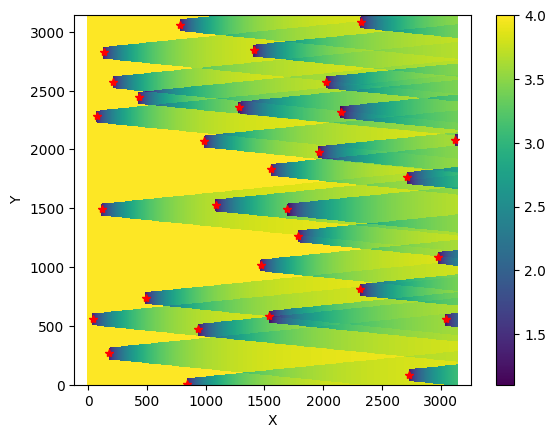

In [ ]:
jensen_wakes1(np.array(coor), 4.0, 1)